In [1]:
import numpy as np
from scipy.linalg import eig, eig_banded, eigh
from scipy.sparse.linalg import eigs, eigsh
from scipy.sparse import eye, diags
import kwant


import matplotlib.pyplot as plt

In [2]:
N = 500
c = np.random.rand(N-1) + np.random.rand(N-1)*1j
b = np.random.rand(N)
H = diags(c, offsets=-1) + diags(b, offsets=0) + diags(c.conj(), offsets=1)
eig_true, eig_vecs = eigh(H.todense())

H_banded = np.array([[0, *c], [*b]])
true_eigvals, true_eigvecs = eig_banded(H_banded)

In [ ]:
plt.mathshow(np.abs(

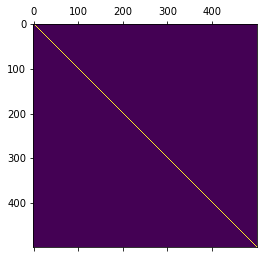

In [4]:
plt.matshow(np.abs(eig_vecs@eig_vecs.T.conj()))

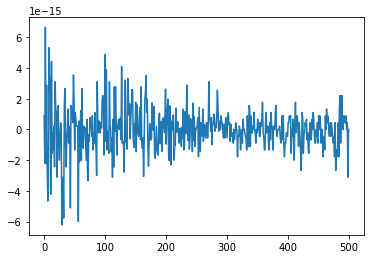

In [3]:
plt.plot(np.sort(eig_true)-np.sort(true_eigvals))

In [2]:
%%time
# N = 1000
# a = 0.1
# Emax = 1
# Emin = -1

# E_max_abs = np.max(np.abs([Emax, Emin]))

# H = diags(np.linspace(Emin, Emax, N))


N = 5000
c = np.random.rand(N-1) + np.random.rand(N-1)*1j
b = np.random.rand(N)
H = diags(c, offsets=-1) + diags(b, offsets=0) + diags(c.conj(), offsets=1)
Emin = eigsh(H, k=1, which='SA', return_eigenvectors=False)[0]
Emax = eigsh(H, k=1, which='LA', return_eigenvectors=False)[0]
E_max_abs = np.max(np.abs([Emax, Emin]))


H_banded = np.array([[0, *c], [*b]])
true_eigvals, true_eigvecs = eig_banded(H_banded)

#true_eigvals = eigsh(H, k=500, which='SM', return_eigenvectors=False)



a = 0.1

def G_operator(ham, Emax, Emin):
    Emax=Emax+0.05
    Emin=Emin-0.05
    E0 = (Emax - Emin)/2
    Ec = (Emax + Emin)/2
    return (ham - eye(ham.shape[0]) * Ec)/E0


def F_operator(ham, Emax, a):
    Emax=Emax+0.05
    E0 = (Emax**2 - a**2)/2
    Ec = (Emax**2 + a**2)/2
    return (ham @ ham - eye(ham.shape[0])*Ec)/E0

G = G_operator(H, Emax, Emin)
F = F_operator(H, E_max_abs, a)
a_r = a/E_max_abs


dos_estimate = kwant.kpm.SpectralDensity(
    H,
    energy_resolution=2*a,
    mean=True,
    bounds=(Emin, Emax)
)

d=int(np.abs(dos_estimate(0)*2*a))
d

CPU times: user 25.9 s, sys: 2.37 s, total: 28.3 s
Wall time: 28.1 s


229

In [3]:
def low_E_filter(ψ_rand, H, k):
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_rand
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H@ψ_nm1
            continue
            
        ψ_np1 = 2*H@ψ_n - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
    return ψ_n

def basis(ψ_proj, H, indices):
    ψ_basis = []
    k = indices[-1]
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_proj
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H.dot(ψ_nm1)
            continue
            
        ψ_np1 = 2*H.dot(ψ_n) - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
        if i in indices:
            ψ_basis.append(ψ_n)
    return ψ_basis

CPU times: user 231 ms, sys: 245 ms, total: 476 ms
Wall time: 473 ms


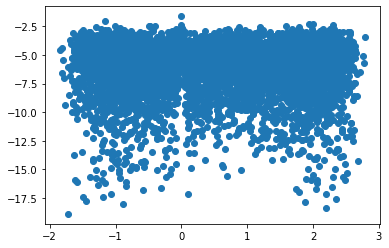

In [6]:
%%time
#true_eigvals, true_eigvecs = eig(H.todense())
ψ_rand = np.random.rand(N)+ np.random.rand(N)*1j
ψ_rand = ψ_rand/np.linalg.norm(ψ_rand)
ψ_proj = low_E_filter(ψ_rand, F, int(12*E_max_abs/a))
ψ_proj = ψ_proj/np.linalg.norm(ψ_proj)

plt.scatter(np.real(true_eigvals), np.log(np.abs(true_eigvecs.T.conj()@ψ_proj)))

In [6]:
%%time
n = int((d*3 - 1)/2)
Kd = int(n*np.pi/a_r)
indices = np.arange(np.pi/a_r, (n+1)*np.pi/a_r, np.pi/a_r).astype(int)

ψ_basis = basis(ψ_proj, G, indices) ## The bottleneck step

norm = np.linalg.norm(ψ_basis, axis=1)
ψ_basis = ψ_basis/norm[:, np.newaxis]

CPU times: user 2.52 s, sys: 64 ms, total: 2.58 s
Wall time: 2.58 s


In [7]:
%%time
S = ψ_basis@ψ_basis.T.conj()
H_proj = ψ_basis@H.dot(ψ_basis.T.conj())

CPU times: user 299 ms, sys: 41 ms, total: 340 ms
Wall time: 337 ms


In [8]:
%%time
s, V = eig(S)
indx = np.abs(s)>1e-12
lambda_s = np.diag(1/np.sqrt(s[indx]))
U = V[:, indx]@lambda_s

H_proj_red = U.T.conj()@H_proj@U

CPU times: user 214 ms, sys: 5 ms, total: 219 ms
Wall time: 212 ms


In [9]:
%%time
# could use eigh, H_proj_red is approximately hermitian
eigvalues, eigvectors = eig(H_proj_red)

CPU times: user 246 ms, sys: 1.01 ms, total: 247 ms
Wall time: 242 ms


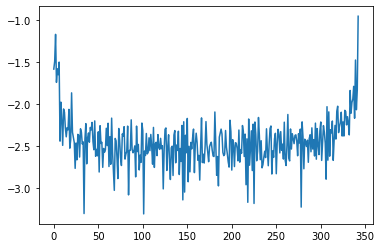

In [10]:
plt.plot(np.log10(np.diff(np.sort(np.real(eigvalues)))))

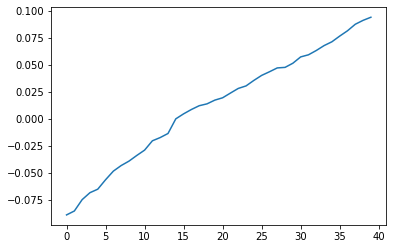

In [11]:
out_indx = a >= np.abs(eigvalues)
plt.plot(np.sort(np.real(eigvalues[out_indx])))

(-0.1, 0.1)

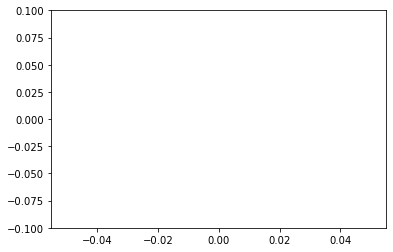

In [13]:
out_indx = a >= np.abs(true_eigvals)
plt.plot(np.sort(np.real(true_eigvals[out_indx])))
plt.ylim([-a,a])

In [12]:
import kwant

dos = kwant.kpm.SpectralDensity(
    H_proj_red,
    mean=True,
    bounds=(-a, a),
    energy_resolution=0.005
)

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


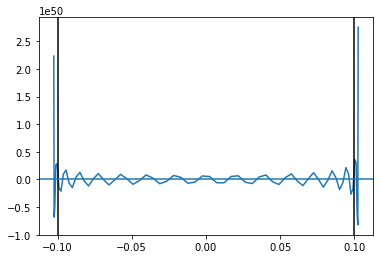

In [13]:
plt.plot(*dos())
plt.axvline(-a, c='k')
plt.axvline(a, c='k')
# plt.xlim(-a, a)
# plt.ylim(-1e59, 1e59)
plt.axhline(0)
plt.show()